# **Associations between aversive learning processes and transdiagnostic psychiatric symptoms revealed by large-scale phenotyping**

---

# Behavioural analyses and model fitting

This notebook performs analyses of behavioural data, constructs candidate behavioural models, and then explores the results of the winning model.

## Imports

In [1]:
import sys
sys.path.insert(0, '../code')
import dill
import re
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
import json
import os
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, iqr
from bambi import Model
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from DMpy.observation import softmax
import pymc3 as pm
import pandas as pd
import copy
from learning_models import *
from tqdm import tqdm
import seaborn as sns
import matplotlib
import matplotlib.font_manager as font_manager

# Nice fonts
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Nice colours
pal = ['#4f4f4f', '#B80044', '#0e79b2']
light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get the data

First we load the preprocessed data, which represents subjects' positions on each "trial"

In [2]:
model_data_path = '../Data/modelling_data'
qns = pd.read_csv('../Data/qns_full.csv')

dfs = []
count = 0

for i in tqdm([j for j in os.listdir(model_data_path) if 'combined' not in j]):
    temp_df = pd.read_csv(os.path.join(model_data_path, i))
    # Exclude subjects with too few trials or limited response variability, or we're missing questionnaire data for the subject
    if temp_df['Response'].std() > 0.05 and re.search('(?<=data_)[a-z0-9]+', i).group() in qns.Subject.tolist():
        dfs.append(temp_df)

data = pd.concat(dfs)
data.Response = 1 - data.Response
data['health'] = data['health'].fillna(-999)
data.to_csv(os.path.join(model_data_path, 'combined_modelling_data.csv'))
print "Number of subjects = {0}".format(len(data.Subject.unique()))
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:10<00:00, 39.62it/s]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


Number of subjects = 400


,Outcome,Outcome_2,Response,Subject,Unnamed: 0,health,score,trial
0,0,1,0.948074,data_sub0000,0,0.8137,725.0,1
1,0,1,0.644873,data_sub0000,1,0.5376,1125.0,2
2,1,1,0.802167,data_sub0000,2,0.2616,1525.0,3
3,0,1,0.110301,data_sub0000,3,1.0000,225.0,4
4,0,1,0.374528,data_sub0000,4,0.9137,725.0,5


# Model-free analyses

Before doing any modelling, we want to see what the behaviour looks like.

A metric that is commonly used in value-based learning tasks is the win-stay/lose-shift measure - i.e. how much do subjects stay with the option chosen when they win, and how much do they shift when they lose? We can calculate a similar measure here by looking at how much subjects change their position following danger (an asteroid) and safety (no asteroid) in the position they chose. If subjects are learning from these outcomes, they should be more likely to move following threat and stay following safety.

First, we need to calculate how much subjects changed position on each trial (i.e. the difference between position on trial $n$ minus their position on trial $n-1$

In [3]:
model_data_path = '../Data/modelling_data'
data = pd.read_csv(os.path.join(model_data_path, 'combined_modelling_data.csv'))

In [4]:
change_data = data.copy().reset_index(drop=True)
change_data['change'] = change_data['Response'].diff()
change_data.loc[np.roll(change_data['health'], 1) == -999, 'change'] = np.nan

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

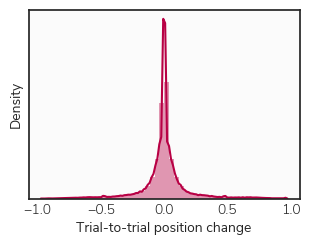

In [5]:
plt.figure(figsize=(3.5, 2.5), dpi=100)
sns.distplot(change_data.loc[~change_data['change'].isnull(), 'change'], color=pal[1])
plt.xlabel("Trial-to-trial position change")
plt.yticks([]);
plt.ylabel("Density")

From an initial look, it seems as though subjects generally don't change their position much, which makes sense - the best option stays the best for a reasonable number of trials.

### Shifting after safety and danger

We can then use the outcomes to see how this change in position varies depending on whether they encountered safety or danger.

In [6]:
ws_ls_df = dict(Subject=[], ls=[], ws=[])

for sub in tqdm(data['Subject'].unique()):
    temp_df = change_data[change_data['Subject'] == sub]
    ls = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 0) & (temp_df['Response'] >= 0.5)) | ((temp_df['Outcome_2'].shift(1) == 0) & (temp_df['Response'] < 0.5)), 'change']).mean()
    ws = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 1) & (temp_df['Response'] >= 0.5)) | ((temp_df['Outcome_2'].shift(1) == 1) & (temp_df['Response'] < 0.5)), 'change']).mean()
    ws_ls_df['Subject'].append(sub.replace('data_', ''))
    ws_ls_df['ls'].append(ls)
    ws_ls_df['ws'].append(ws)
    
ws_ls_df = pd.DataFrame(ws_ls_df)
ws_ls_df.to_csv('../Data/behavioural_measures.csv')
ws_ls_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 45.63it/s]


,Subject,ls,ws
0,sub0000,0.367733,0.099519
1,sub0001,0.171024,0.110099
2,sub0002,0.259189,0.089088
3,sub0003,0.151782,0.082572
4,sub0004,0.301450,0.076321


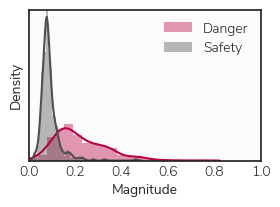

In [7]:
plt.figure(figsize=(3, 2), dpi=100)
sns.distplot(ws_ls_df['ls'], color=pal[1], label='Danger')
sns.distplot(ws_ls_df['ws'], color=pal[0], label='Safety')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.yticks([]);
plt.savefig('../figures/position_changes.svg')

On the whole, subjects tended to change position more after danger than safety, as we would expect. This indicates that subjects are adjusting their behaviour in response to the outcomes in the task.

### Number of crashes

In [8]:
crashes = []

for sub in data.Subject.unique():
    crashes.append((data[data.Subject == sub]['health'] < 0).sum())

In [9]:
print('Mean (SD) number of crashes = {0} ({1})'.format(np.mean(crashes), np.std(crashes)))
print('Median (IQR) number of crashes = {0} ({1})'.format(np.median(crashes), iqr(crashes)))


Mean (SD) number of crashes = 1.935 (1.96742852475)
Median (IQR) number of crashes = 1.0 (2.0)


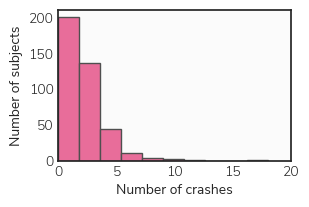

In [10]:
plt.figure(figsize=(3, 2), dpi=100)
plt.hist(crashes, color=light_pal[1], label='Danger', ec=pal[0])
# plt.legend()
plt.xlim(0, 20)
plt.xlabel("Number of crashes")
plt.ylabel("Number of subjects")
plt.savefig('../figures/crashes.svg')

# Computational models

Next, we turn to the modelling. Here, we will use models to understand how subjects learn about the likelihood of safety associated with each of the two locations in the game. 

## Beta models

The family of models we are predominantly interested in is referred to as the Asymmetric Leaky Beta family, which we have used in previous work to model aversive learning in a more traditional lab-based task [(Wise et al., 2019, PLOS Computational Biology)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007341).

These models assume that subjects are estimating a beta distribution of the likelihood of receiving a shock from each stimulus independently. 

### Basic model

This model is the most basic model, which forms the foundation for all further models.

#### Updates

The beta distribution for each location ($X$ and $Y$) is updated on each trial as follows. This equation represents the updates for location $X$, but this is repeated for $Y$.

\begin{array}{c}{A_{t+1}^{X}=(1-\lambda) \cdot A_{t}^{X}+\text { outcome } t^{X} \cdot \tau^{+} \cdot W} \\ {B_{t+1}^{X}=(1-\lambda) \cdot B_{t}^{X}+\left(1-\text { outcome }_{t}^{X}\right) \cdot \tau^{-} \cdot W}\end{array}

Here $A$ and $B$ represent the two parameters of the beta distribution, and correspond to safety and danger respectively, and are represented by the variables `A_X`, `B_X`, `A_Y`, `B_Y` in the code.

We build decay (or leak, hence the "leaky" beta) into the model so that it does not accumulate evidence to infinity, and is able to be influenced by recent trials. This parameter is represented by $\lambda$ in the equation above and the `decay` variable in the code, although we use $(1 - \lambda)$ so that higher values of the decay parameter indicate more decay, as this this is more intuitive. This decay happens on each trial, for both $A$ and $B$, by multiplying the existing value of these parameters by $\lambda$, which is itself bounded between 0 and 1.

We then add the outcome of the current trial to the current value of $A$ or $B$, depending on whether it was danger (a value of 0) or safety (a value of 1). This outcome is first multiplied by the update rate, which is $\tau^+$ for safety and $\tau^-$ for danger (`tau_p` and `tau_n` respectively in the code). This allows the update occur at different rates for different types of outcome, and is why we describe the model as "asymmetric". 

Finally, we allow the "unchosen" location to be updated to a lesser extent than the "chosen" location, as it appeared subjects in our pilot data tended to be less influenced by the location they had not chosen. This is achieved by multiplying the outcome by a value $W$, which is between 0 and 1. On each trial, $W$ is determined as follows:

$$
W_{t+1}^{X}=\begin{array}{c}{1 \, if chosen } \\ {\omega \, if unchosen }\end{array}
$$

So that the unchosen option is downweighted by free parameter $\omega$, represented by `omega` in the code.

#### Calculation of safety probability and uncertainty

We then get the estimated probability of safety associated with each location by taking the mean of the current beta distribution ($P$ here represents safety probability):

$$
P_{t+1}^{X}=\frac{A_{t+1}^{X}}{\left(A_{t+1}^{X}+B_{t+1}^{X}\right)}
$$

The uncertainty around this estimate ($\sigma$) is then given by the variance of this distribution:

$$
\sigma_{t+1}^{X}=\frac{A_{t+1}^{X} \cdot B_{t+1}^{X}}{\left(A_{t+1}^{X}+B_{t+1}^{X}\right)^{2} \cdot\left(A_{t+1}^{X}+B_{t+1}^{X}+1\right)}
$$

#### Position calculation

We need to then use these safety probability estimates to work out where to position the spaceship. This should be towards the top or bottom, if either of these locations are expected to be safest, and nearer the center if neither is favourable. We calculate position ($pos$) as follows:

$$
p o s_{t+1}=\frac{\left(P_{t+1}^{X}-P_{t+1}^{Y}\right)+1}{2}
$$

### A visual demonstration

All this maths is great, but it a visual demonstration illustrates how this works more intuitively.

Here we see the beta distributions for the two options develop over time, along with the calculated player position. 


![BetaUrl](https://raw.githubusercontent.com/tobywise/tobywise.github.io/master/img/beta_distributions_small.gif "Beta distributions")

In [11]:
# Starting position - not actually used but is required to stop DMpy getting confused
pos = Parameter('pos', 'fixed', mean=0.5, dynamic=True)

# A and B parameters for each location (X and Y) - these are fixed at 1, i.e. equal evidence for both safety and danger
A_X = Parameter('A_X', 'fixed', lower_bound=1, upper_bound=10, mean=1, dynamic=True)
B_X = Parameter('B_X', 'fixed', lower_bound=1, upper_bound=10, mean=1, dynamic=True)
A_Y = Parameter('A_Y', 'fixed', lower_bound=1, upper_bound=10, mean=1, dynamic=True)
B_Y = Parameter('B_Y', 'fixed', lower_bound=1, upper_bound=10, mean=1, dynamic=True)
 
# Decay rate (lambda)
decay = Parameter(r'decay', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.06, variance=100)

# Positive and negative weights for the asymmetric model
tau_p = Parameter(r'tau_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)
tau_n = Parameter(r'tau_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)

# Weighting of the unchosen position, omega
omega = Parameter(r'omega', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.5, variance=100)

# Define model
ALB_model = DMModel(ALB, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega], None, None,
                               name='ALB', logp_function='beta')

### Model with softmax decision rule

From pilot data, we observed that subjects tended to avoid the middle of the screen. We therefore tested a model that encouraged position estimates away from the centre by putting them through a softmax function. Note that this is not used for its typical use, i.e. turning value estimates into choice probabilities, here it is used only because it allows us to ensure that values occur mostly at the top or bottom of the screen.

Incorportating this means that the position calculated above is then modified according to the following rule, where $\beta$ represents an inverse temperature parameter (`temperature` in the code, bounded between 0 and 1).

$$
p o s_{t+1}=\frac{e^{\left(\beta \cdot p o s_{t+1}\right)}}{e^{\left(\beta \cdot p o s_{t+1}\right)}+e^{\left(\beta \cdot\left(1-p o s_{t+1}\right)\right)}}
$$

In [12]:
# Softmax temperature
temperature = Parameter(r'temp', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100^2)

# Define model
ALB_softmax_model = DMModel(ALB_softmax, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega, temperature], None, None,
                               name='ALB softmax', logp_function='beta')

### Model with choice stickiness

We next tested a model that incorporated a form of choice "stickiness", whereby the safety probability of an option on trial $t+1$ was inflated if it had been chosen on trial $t$. This had the effect of making the location on the screen that was chosen more likely to be chosen on the following trial, regardless of outcome.

The amount of stickiness was determined by stickiness parameter $S$ (represented by `stickiness` in the code). An exponent was chosen to ensure that $P$ did not take values above 1.

\begin{equation}
P_{t+1}^{X}=\begin{array}{l}{{P_{t+1}^{X}}^{S} \text { if chosen }} \\ {P_{t+1}^{X} \text { if unchosen }}\end{array}
\end{equation}

In [13]:
# Stickiness parameter
stickiness = Parameter(r'stickiness', 'normal', lower_bound=0.01, upper_bound=1, mean=1, variance=5)

# Define model
ALB_sticky_model = DMModel(sticky_ALB, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega, temperature, stickiness], None, None,
                               name='ALB sticky', logp_function='beta')

### Model incorporating weighting by variance

The previous models assumed subjects weigh each option equally when determining the optimal position. However this might not be the case - for example subjects may weight the top and bottom options based on their variance (i.e. their uncertainty), and so we developed a model that allowed us to test this hypothesis.

Here, we first calculate a bias measure ($\sigma^{bias}$) that will allow us to bias the calculated position towards the top or bottom, depending on their variance ($\sigma$).

\begin{equation}
\sigma^{bias}_t = \frac{\sigma^X_t}{\sigma^X_t + \sigma^Y_t}
\end{equation}

When calculating the spaceship position, we then use the safety probability for each option ($P$), weighted by this measure. The influence of this bias is itself modulated by a free parameter $\pi$ (the variable `var_weight` in the code). This weighted measure is referred to as $Pw$ and is calculated for positions $X$ and $Y$ as follows:

\begin{equation}
Pw^X_t = P^X_t \cdot (1 - \sigma^{bias}_t \cdot \pi)
\end{equation}

\begin{equation}
Pw^Y_t = P^Y_t \cdot (1 - (1 - \sigma^{bias}_t) \cdot \pi)
\end{equation}

In [14]:
# Variance weighting
var_weight = Parameter(r'var_weight', 'normal', lower_bound=0, upper_bound=0.9, mean=0, variance=100)

ALB_var_model = DMModel(ALB_var, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega, temperature, var_weight], None, None,
                               name='ALB variance', logp_function='beta')


### Model with UCB choice rule

Alternatively, subjects may incorporate uncertainty in a different way - taking a kind of "best case scenario" based on the variance of the distribution. This can be formalised as an upper confidence bound "UCB" rule, where take a particular point on the upper side of the variance around the estimated safety probability. The exact point of this distribution chosen can be estimated as a free parameter - here this is $\omega$ (referred to as `ucb_omega` in the code). Using this the UCB is calculated using the following equation:

\begin{equation}
UCB^X_t = P^X_t + \omega \cdot \sqrt{\sigma^X_t}
\end{equation}

The subject's position is then calculated as before, but using the UCB values in place of the estimated safety probability:

\begin{equation}
pos_t = \frac{(UCB^X_t - UCB^Y_t) + 1}{2}
\end{equation}

In [15]:
ucb_omega = Parameter(r'ucb_omega', 'normal', lower_bound=0, upper_bound=0.9, mean=0, variance=100)

ALB_UCB_model = DMModel(ALB_UCB, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega, temperature, ucb_omega], None, None,
                               name='ALB UCB', logp_function='beta')


## Reinforcement learning models

We chose to focus on beta models for this project. This is because of a couple of important properties: Firstly their probabilistic nature means they inherently represent uncertainty; this is a little less straightforward when using reinforcement learning (RL) models. Secondly, we and others have found that they provide a better fit to data from lab-based aversive learning tasks than RL models.

However, given their prevalence across the field, we included a couple of simple RL models for comparison.

### Standard Rescorla-Wagner

This is the commonly used Rescorla-Wagner model, where the safety probability estimate ($P$) for each location is updated according to a prediction error signal (i.e. the difference between observed and predicted outcome) weighted by a learning rate ($\alpha$, represented by `alpha` in the code.

\begin{equation}
P_{t+1}^X = P_t^X + \alpha\cdot(outcome^X - P_t^X)
\end{equation}

The safety probability estimates for the two locations are then combined as in the previous models, subject to downweighting of the unchosen option.

In [16]:
# Position and safety probability parameters, assuming no bias to begin with (i.e. a value of 0.5)
pos = Parameter('pos', 'fixed', mean=0.5, dynamic=True)
prob_0 = Parameter('prob_0', 'fixed', lower_bound=0, upper_bound=1, mean=0.5, variance=5, dynamic=True)
prob_1 = Parameter('prob_1', 'fixed', lower_bound=0, upper_bound=1, mean=0.5, variance=5, dynamic=True)

# Learning rate
alpha = Parameter(r'alpha', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Initialise model
rescorla_wagner_model = DMModel(rescorla_wagner, [pos, prob_0, prob_1, alpha, omega, temperature], None, None,
                               name='Rescorla wagner', logp_function='beta')

c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1464: UserWarning: Parameter is specified as fixed, ignoring variance & bounds
  warnings.warn("Parameter is specified as fixed, ignoring variance & bounds")


### Dual learning rate model

Previous research indicates that people have a tendency to learn about positive and negative events at different rates. This model accounts for this tendency by allowing different learning rates for better and worse than expected outcomes (i.e. positive and negative prediction errors respectively).

First we calculate the prediction error ($\delta$):

This is then used in the same way as the previous Rescorla-Wagner model, however we now have two learning rates, $\alpha^+$ for positive PEs and $\alpha^-$ for negative ones. These are specified in the code as `alpha_p` and `alpha_n` respectively.

\begin{array}{c}{\delta=\text { outcome }^{\mathrm{X}}-P_{\mathrm{t}}^{\mathrm{X}}} \\ {P_{\mathrm{t}+1}^{\mathrm{X}}=P_{\mathrm{t}}^{\mathrm{X}}+\begin{array}{l}{\alpha^{+} \cdot \delta \text { if } \delta_{t}>0} \\ {\alpha^{-} \cdot \delta \text { if } \delta_{t}<0}\end{array}}\end{array}


In [17]:
# Learning rates for dual learning rate model
alpha_n = Parameter(r'alpha_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
alpha_p = Parameter(r'alpha_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Initialise dual learning rate model
dual_lr_model = DMModel(dual_lr, [pos, prob_0, prob_1, alpha_n, alpha_p, omega, temperature], None, None,
                               name='Dynamic learning rate', logp_function='beta')

### Save the model instances to disk

In [18]:
models = [ALB_model, ALB_softmax_model, ALB_var_model, ALB_sticky_model, rescorla_wagner_model, dual_lr_model, ALB_UCB_model]

for m in tqdm(models):
    with open('../Data/models/{0}.pkl'.format(m.name.replace(' ', '_')), 'wb') as file:
        dill.dump(m, file)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.12it/s]


In [19]:
models = [ALB_model, ALB_softmax_model, ALB_var_model, ALB_sticky_model, rescorla_wagner_model, dual_lr_model, ALB_UCB_model]


## Model fitting

Next, it's time to actaully fit the models. This is done using variational inference as it provides almost equivalent results to MCMC (variational inference typically tends to fail when posterior distributions aren't gaussian - this shouldn't be the case here), and takes _far_ less time with a sample this large - a few hours as opposed to a few days.

> **_Note:_**    This cell isn't run here as running all these models in serial is slow. The saved model instances are instead run on a cluster using the `fit_behavioural_model.py` script in the `code` directory.


In [20]:
# for m in models[3:]:
#     print "Fitting {0}".format(m.name)
    
#     # Variational
#     m.fit(os.path.join(model_data_path, 'combined_modelling_data.csv'), model_inputs=['Outcome_2'], response_transform=beta_response_transform, 
#           fit_method='variational', fit_kwargs={'n': 25000}, hierarchical=True, plot=False, suppress_table=True, fit_stats=True)

## Load the fitted models

Afrer the models have been fit, we can reload them and look at the results.

In [21]:
models = []

for m in tqdm([i for i in os.listdir('../Data/models') if '_fit' in i]):
    with open(os.path.join('../Data/models', m), 'rb') as f:
        models.append(dill.load(f))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.36s/it]


## Model comparison

We use the Watanabe-Akaike Information Criterion as an index of model fit - lower is better. 

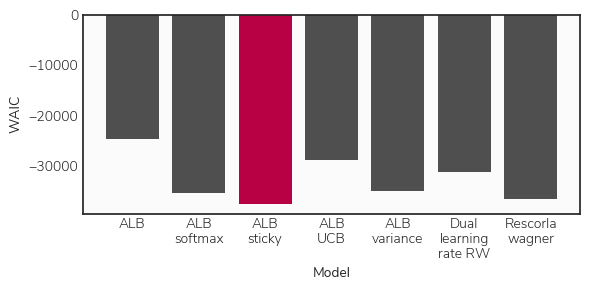

In [22]:
# Plot the WAIC scores for each model
plt.figure(figsize=(6, 3), dpi=100, facecolor='white')
waic_pal = [pal[0]] * len(models)
waics = np.array([m.WAIC for m in models])
winning_idx = np.where(waics == waics.min())[0][0]
waic_pal[winning_idx] = pal[1]
plt.bar([m.name.replace(' ', '\n').replace('Dynamic', 'Dual').replace('rate', 'rate RW') for m in models], waics, color=waic_pal)
plt.ylabel('WAIC')
plt.xlabel("Model")
plt.tight_layout()

# Save the figure
# plt.savefig('../figures/model_comparison.svg', facecolor='#fbfbfb')
# plt.savefig('../figures/model_comparison.png', facecolor='#fbfbfb')

From this, it appears that the asymmetric leaky beta model with a stickiness parameter provides the best fit the data (although not by a huge margin).

### Simulate some data

Next, we'll take estimated parameter values (as we estimate the entire posterior distribution for each parameter, we just use the mean value here) and use this to simulate some data.

In [23]:
sim, _ = models[winning_idx].simulate(response_variable='value', model_inputs=['Outcome_2'])

Simulating data from 400 sets of parameter values
Saving simulated results to 


And we can plot 3 random subjects to demonstrate correspondence between the simulated and true data.

Of interest, we end up here with a subject who didn't really move - out exclusion criteria were designed to exclude subjects like this but were likely not strict enough. Thankfully we have very few subjects who behave like this so it shouldn't have a huge impact on our results.

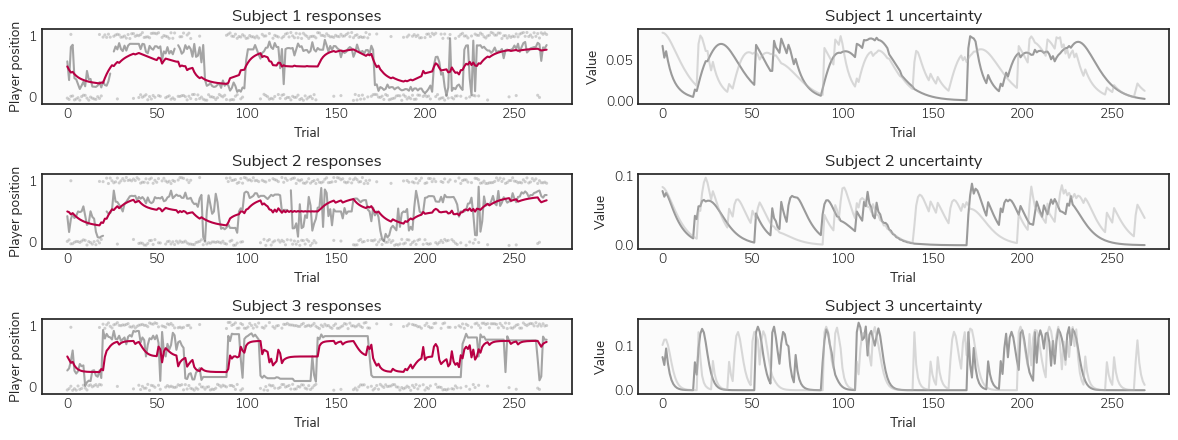

In [24]:
n_subs = 3

random_subs = np.random.choice(sim.results.Subject.unique(), n_subs, replace=False)

f, ax = plt.subplots(n_subs, 2, figsize=(12, 1.5 * n_subs), facecolor='white', dpi=100)

for n, sub in enumerate(random_subs):
    temp_data = sim.results[sim.results.Subject == sub].reset_index()
    ax[n, 0].plot(temp_data.True_response, color='#4f4f4f', alpha=0.5)
    ax[n, 0].plot(temp_data.Response, color='#B80044')
#     ax[n, 0].plot(temp_data['value_0'], color='#3a3a3a', alpha=0.5)
#     ax[n, 0].plot(temp_data['value_1'], color='#b5b5b5', alpha=0.5)
    ax[n, 0].set_ylabel("Player position")
    ax[n, 0].set_xlabel("Trial")
    ax[n, 0].set_title("Subject {0} responses".format(n+1))
    ax[n, 0].set_ylim(0, 1)
    
    ax[n, 1].plot(temp_data['var_0'], color='#3a3a3a', alpha=0.5)
    ax[n, 1].plot(temp_data['var_1'], color='#b5b5b5', alpha=0.5)
    ax[n, 1].set_title("Subject {0} uncertainty".format(n+1))
    ax[n, 1].set_ylabel("Value")
    ax[n, 1].set_xlabel("Trial")
    
    # Outcomes
    temp_data.loc[temp_data['Outcome'] == 0, 'Outcome'] = np.nan
    temp_data.loc[temp_data['sim_model_input_0'] == 0, 'sim_model_input_0'] = np.nan
    ax[n, 0].scatter(range(len(temp_data)), temp_data.Outcome + (np.random.random(len(temp_data)) - 0.5) * 0.1, 
                     edgecolors='none', facecolors='#a3a3a3', alpha=.5, s=5)
    ax[n, 0].scatter(range(len(temp_data)), temp_data.sim_model_input_0 - 1 + (np.random.random(len(temp_data)) - 0.5) * 0.1, 
                     edgecolors='none', facecolors='#a3a3a3', alpha=.5, s=5)
    
    ax[n, 0].set_ylim(-0.1, 1.1)

plt.tight_layout()

plt.savefig('../figures/ALB_sticky_simulated.png', facecolor='#fbfbfb')
plt.savefig('../figures/ALB_sticky_simulated.svg', facecolor='#fbfbfb')

### Validation of safety value and uncertainty measures

The measures of uncertainty and safety value derived from the model is purely model-based, and therefore fairly abstract. It is therefore important to validate these measure by ensuring they relate to purely behavioural markers that we would expect to be dependent upon them.

Here we will use the extent to which subjects change their position on each trial as a behavioural measure. Subjects should change their position more when they are more uncertain about the option they think is best. If I've positioned myself at the top of the screen, but I'm very unsure about whether this is a safe place to be, I should be more likely to switch to the bottom of the screen if I encounter a bad outcome at the top, or a good outcome at the bottom. In contrast, when there is a clear difference in value between the options (e.g. the top is clearly the best), they should switch position less, whereas when this isn't clear they should be more likely to switch.

In [25]:
# Calculate absolute position change
change_data['abs_change'] = np.abs(change_data['change'])
change_data['abs_change'] = change_data['abs_change'].shift(-1)  # Line up change in position with model measures (it's currently lagged by one trial)

change_data['uncertainty'] = np.mean(sim.results[['var_0', 'var_1']], axis=1)
change_data['value_diff'] = np.abs(sim.results['value_0'] - sim.results['value_1'])

# Scale 
change_data[['abs_change', 'uncertainty', 'value_diff']] = scale(change_data[['abs_change', 'uncertainty', 'value_diff']])

In [26]:
change_data.head()

,Unnamed: 0,Outcome,Outcome_2,Response,Subject,Unnamed: 0.1,health,score,trial,change,abs_change,uncertainty,value_diff
0,0,0,1,0.948074,data_sub0000,0,0.8137,725.0,1,NaN,1.272640,1.174907,-0.977358
1,1,0,1,0.644873,data_sub0000,1,0.5376,1125.0,2,-0.303202,0.351013,1.177192,-0.584865
2,2,1,1,0.802167,data_sub0000,2,0.2616,1525.0,3,0.157294,3.727634,1.625524,-0.617333
3,3,0,1,0.110301,data_sub0000,3,1.0000,225.0,4,-0.691865,1.026454,1.412841,-0.195234
4,4,0,1,0.374528,data_sub0000,4,0.9137,725.0,5,0.264227,1.679068,1.229698,0.123433


We'll use Bayesian hierarchical regression to test this, predicting absolute position change (we don't care which direction subjects are moving) from uncertainty around the option where subjects had positioned themselves, within subject. 

The code here is a bit awkward - we build the model using Bambi (as it makes the specification of these hierarchical models easy), but then we use PyMC3 directory to fit the model using variational inference, as MCMC takes a long time for this model.

In [27]:
model = Model(change_data, dropna=True)
results = model.add(
    'abs_change ~ uncertainty + value_diff',
    random=['uncertainty|Subject', 'value_diff|Subject', '1|Subject']
)
model.build('pymc')


with model.backend.model:
    approx = pm.fit(n=80000, random_seed=123)
    trace = pm.sample_approx(approx, draws=6000)

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\bambi\models.py:137: UserWarning: Automatically removing 1509/107600 rows from the dataset.
  warnings.warn(msg)
Average Loss = 1.4604e+05: 100%|█████████████████████████████████████████████████| 80000/80000 [19:58<00:00, 66.73it/s]
Finished [100%]: Average Loss = 1.4604e+05


In [28]:
model.backend

In [29]:
summary = pm.summary(trace, varnames=['uncertainty', 'value_diff']).reset_index()
summary = summary.rename(columns={'hpd_2.5': 'hpd0.95_lower', 'hpd_97.5': 'hpd0.95_upper', 'index': 'Parameter'})
summary['Parameter'] = ['Uncertainty', 'Value\ndifference']
summary

,Parameter,mean,sd,mc_error,hpd0.95_lower,hpd0.95_upper
0,Uncertainty,0.145756,0.003256,0.000046,0.139142,0.151818
1,Value\ndifference,-0.037706,0.003364,0.000044,-0.044035,-0.030892


From the results table it's clear that there's a strong overall effect of uncertainty - subjects tend to change their position more when they are more uncertain about the option where they were positioned, and less when there's a clear difference between options.

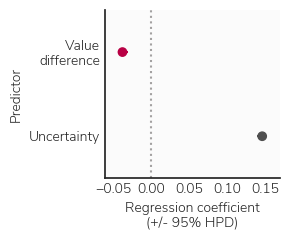

In [30]:
plt.figure(figsize=(3, 2.5), dpi=100)
plt.scatter(summary['mean'], range(len(summary)), color=[pal[0], pal[1]])
plt.errorbar(summary['mean'], range(len(summary)), 
             xerr=[summary['mean'] - summary['hpd0.95_lower'], summary['hpd0.95_upper'] - summary['mean']], 
               fmt='none', label=None, color=[pal[0], pal[1]])
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 1.5)
plt.yticks(range(len(summary)), summary['Parameter'].values)
plt.xlabel("Regression coefficient\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("Predictor", fontweight='light')
plt.xticks(np.arange(-0.05, 0.2, 0.05))
sns.despine()

plt.tight_layout()
plt.savefig('../figures/value_uncertainty_validation.svg')

## Parameter values

### Table showing parameter values

In [31]:
models[winning_idx].parameter_table.head()

,Subject,mean_decay,mean_omega,mean_stickiness,mean_tau_n,mean_tau_p,mean_temp,sd_decay,sd_omega,sd_stickiness,...,hpd_2.5_stickiness,hpd_2.5_tau_n,hpd_2.5_tau_p,hpd_2.5_temp,hpd_97.5_decay,hpd_97.5_omega,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp
0,data_sub0000,0.282379,0.708362,0.908250,0.661819,0.095097,0.896985,0.047912,0.131705,0.087647,...,0.734336,0.363061,0.018358,0.772343,0.373480,0.878719,0.991213,0.958977,0.221937,0.980156
1,data_sub0001,0.208660,0.817029,0.883371,0.779624,0.277513,0.806390,0.040307,0.083349,0.095938,...,0.651968,0.487663,0.088144,0.707715,0.288373,0.897435,0.986193,0.982927,0.514157,0.882515
2,data_sub0002,0.412637,0.703319,0.853576,0.605603,0.262691,0.901509,0.067512,0.140613,0.090696,...,0.673970,0.319692,0.097685,0.747594,0.545388,0.890528,0.971920,0.873886,0.465949,0.969262
3,data_sub0003,0.183998,0.743248,0.915910,0.746176,0.328035,0.781923,0.030573,0.138686,0.094421,...,0.719075,0.402549,0.149147,0.651546,0.260656,0.887280,0.997604,0.956626,0.533144,0.915673
4,data_sub0004,0.413523,0.696093,0.846082,0.681088,0.196585,0.848612,0.077869,0.147440,0.099003,...,0.636378,0.380692,0.035117,0.708919,0.577974,0.882806,0.977465,0.918913,0.389805,0.946148


### Plot distributions of estimated values for each parameter

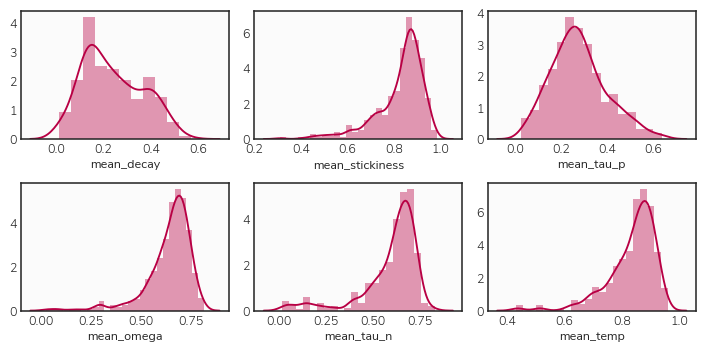

In [32]:
# parameters = [c for c in ALB_var_model.parameter_table.columns if 'mean' in c]
parameters = [c for c in models[winning_idx].parameter_table.columns if not 'Subject' in c and not 'error' in c and not 'sd_' in c and not 'hpd' in c and 'offset' not in c]

f, ax = plt.subplots(2, np.ceil(len(parameters) / 2.).astype(int), figsize=(8, 4), dpi=90, facecolor='white')

for n, p in enumerate(parameters):
    sns.distplot(models[winning_idx].parameter_table[p], ax=ax[n % 2, n / 2], color=pal[1])

plt.tight_layout();

## Plot $\tau$ values

In previous research, we've shown that subjects have a bias towards learning more from danger than safety. To take a look at this here, we can compare the values for the $\tau^+$ and $\tau^-$ parameters, representing updates in response to safety and danger respectively.

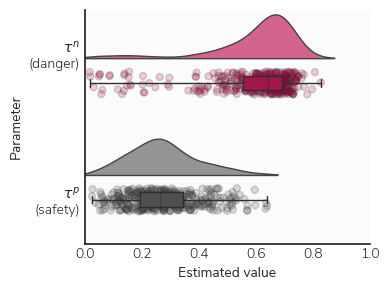

In [33]:
# Get tau values
tau_df = models[winning_idx].parameter_table[['mean_tau_p', 'mean_tau_n', 'Subject']].copy()
tau_df = pd.melt(tau_df, id_vars='Subject', value_vars=[i for i in tau_df.columns if 'mean' in i],
                                                        value_name='Estimated value', var_name='Parameter')
tau_df['Parameter'] = tau_df['Parameter'].str.replace('mean_tau_p', r'$\tau^p$')
tau_df['Parameter'] = tau_df['Parameter'].str.replace('mean_tau_n', r'$\tau^n$')

# Violin plot - this uses a fork of Seaborn that is capable of doing half-violin plots
plt.figure(figsize=(4, 3), dpi=100, facecolor='white')
violin = sns.violinplot(x='Estimated value', y="Parameter", data=tau_df, inner=None,
              jitter=True, color=".7", lwidth=0, width=0.6, offset=0.17, cut=1,
              linewidth=1, alpha=0.6, palette=pal, zorder=19);
for n, i in enumerate([i for i in violin.collections if isinstance(i, matplotlib.collections.PolyCollection)]):            
    plt.setp(i, facecolor=matplotlib.colors.colorConverter.to_rgba(pal[n], alpha=0.6))
    plt.setp(i, edgecolor=matplotlib.colors.colorConverter.to_rgba('#444444', alpha=1))

# Plot individual data points
sp = sns.stripplot(x='Estimated value', y="Parameter", data=tau_df, 
              jitter=0.08, linewidth=1, alpha=0.2, palette=pal, zorder=1);

# Boxplot
ax = sns.boxplot(x='Estimated value', y="Parameter", data=tau_df, 
                 palette=pal, whis=np.inf, linewidth=1, zorder=0,
           width=0.1, boxprops={"zorder":10, 'alpha':1}, whiskerprops={'zorder':10, 'alpha':1}, 
                 medianprops={'zorder':11, 'alpha':0.5});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
# Set up axes
plt.xlabel("Estimated value");
plt.ylabel("Parameter");
plt.yticks([0, 0.8])
plt.ylim([-0.3, 1.3])
plt.yticks([0, 1], [r'$\tau^p$' + '\n(safety)', r'$\tau^n$' + '\n(danger)'])
plt.xlim(0, 1)

# Make it look nice
sns.despine()
plt.tight_layout()

# Save
plt.savefig('../figures/tau_values.svg', facecolor='#fbfbfb')
plt.savefig('../figures/tau_values.png', facecolor='#fbfbfb')

And we can compare these values statistically

In [34]:
from scipy.stats import ttest_rel

t, p = ttest_rel(models[winning_idx].parameter_table['mean_tau_p'], models[winning_idx].parameter_table['mean_tau_n'])

print("t({0}) = {1} p = {2}".format(len(models[winning_idx].parameter_table), t, p))

t(400) = -26.7588128803 p = 4.53802413372e-91


## Check how well the model captures behaviour

Having identified the best fitting model out of those tested, we want to check that it's actually doing a reasonable job of capturing patterns seen in the true behaviour.

### Fit metrics

First, we'll calculate the $R^2$ for each subject - this metric gives us an idea of how well the model is actually fitting when comparing simulated data to true data. A value of 1 represents perfectly identical data, anything lower is less good. Due to the nature of our data, very high values are quite unlikely. Subjects' exact position in the game is fairly noisy, as it's difficult to position the spaceship precisely given the time constraints. However we should be able to get reasonably high fit scores if the model can capture broad patterns seen in the data, even if its precise trial-to-trial estimate isn't spot on.

We can also calculate Pearson's $R$ as a measure of the simple correlation between data produced by the model and the true data. These values should be above zero if the model is capturing the behaviour well.

In [35]:
r2s = []
rs = []

for sub in sim.results.Subject.unique():
    temp_df = sim.results[sim.results.Subject == sub]
    temp_df = temp_df.dropna(subset=['True_response'])
    r2s.append(r2_score(temp_df['True_response'], temp_df['Response']))
    rs.append(pearsonr(temp_df['True_response'], temp_df['Response'])[0])

r2s = np.array(r2s)
rs = np.array(rs)

Text(0,0.5,'Density')

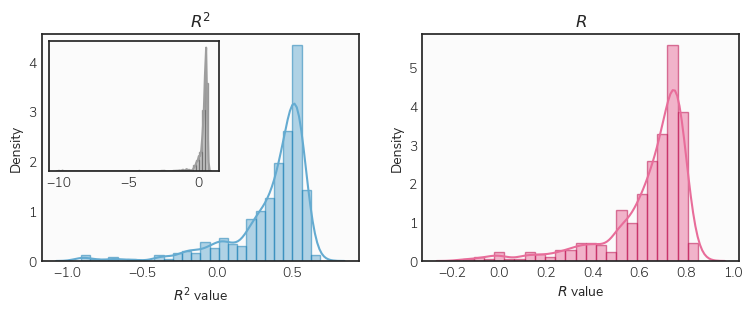

In [36]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

f, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=100)

axins = inset_axes(ax[0], width=1.7, height=1.3, loc='upper left')
axins.set_yticks([])
sns.distplot(r2s, ax=axins, color=light_pal[0], hist_kws={'ec':pal[0], 'alpha':0.5})
sns.distplot(r2s[r2s > -1], ax=ax[0], color=light_pal[2], hist_kws={'ec':pal[2], 'alpha':0.5})
ax[0].set_title(r'$R^2$')
ax[0].set_xlabel(r'$R^2$ value')
ax[0].set_ylabel("Density")

sns.distplot(rs, ax=ax[1], color=light_pal[1], hist_kws={'ec':pal[1], 'alpha':0.5})
ax[1].set_title(r'$R$')
ax[1].set_xlabel(r'$R$ value')
ax[1].set_ylabel("Density")

# plt.savefig('../figures/behaviour_simulated_correlation.svg')

Fro this, we can see that we're getting some fairly good $R^2$ values - the bulk of the density is above zero, with many around 0.5, which is good for this kind of data. Similarly, the $R$ values are almost all quite significantly above zero. It's worth noting that there are a few subjects where the model fails - sadly we're not able to describe every subject perfectly with this model. This may be because they're employing a different strategy, or perhaps they're just not fully engaged with the task.

To quantify the central tendency and spread of these metrics, we'll use the median and interquartile range as they're heavily negatively skewed.

In [37]:
print("Median R^2 = {0}, IQR = {1}".format(np.median(r2s).round(2), iqr(r2s).round(2)))
print("Median R = {0}, IQR = {1}".format(np.median(rs).round(2), iqr(rs).round(2)))

Median R^2 = 0.44, IQR = 0.26
Median R = 0.7, IQR = 0.16


### Recapitulation of behavioural patterns

Having determined that our model generally provides a good fit to the data, it's important to check whether it also reproduces similar general behaviour signatures that are seen in the true data.

One obvious pattern of behaviour from the real data is that subjects shift their position far more after encountering danger than after encountering safety. This is a fairly obvious thing to do, however it's important to check that our model can reproduce these kinds of patterns. If not, it's probably not really representing how real subjects behave. For this, we simply calculate the same kind of win-stay/lose-shift statistics we calculated for the real data on the simulated data from the model.

In [38]:
ws_ls_df = dict(Subject=[], ls=[], ws=[])

change_data_sim = sim.results.copy().reset_index(drop=True)
change_data_sim['change'] = change_data_sim['Response'].diff()
# change_data_sim.loc[np.roll(change_data_sim['health'], 1) == -999, 'change'] = np.nan

for sub in tqdm(sim.results['Subject'].unique()):
    temp_df = change_data_sim[change_data_sim['Subject'] == sub]
    ls = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 0) & (temp_df['Response'] >= 0.5)) | ((temp_df['sim_model_input_0'].shift(1) == 0) & (temp_df['Response'] < 0.5)), 'change']).mean()
    ws = np.abs(temp_df.loc[((temp_df['Outcome'].shift(1) == 1) & (temp_df['Response'] >= 0.5)) | ((temp_df['sim_model_input_0'].shift(1) == 1) & (temp_df['Response'] < 0.5)), 'change']).mean()
    if not np.isnan(ls) and not np.isnan(ws):
        ws_ls_df['Subject'].append(sub.replace('data_', ''))
        ws_ls_df['ls'].append(ls)
        ws_ls_df['ws'].append(ws)
    
ws_ls_df = pd.DataFrame(ws_ls_df)
# ws_ls_df.to_csv('../Data/behavioural_measures.csv')
ws_ls_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:10<00:00, 39.04it/s]


,Subject,ls,ws
0,sub0000,0.177235,0.023201
1,sub0001,0.118206,0.023344
2,sub0002,0.225668,0.041024
3,sub0003,0.101579,0.022075
4,sub0004,0.244202,0.042257


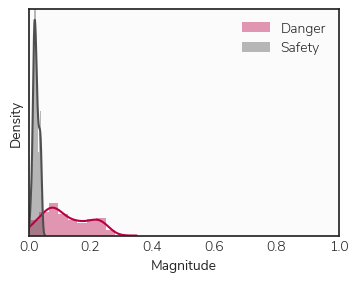

In [39]:
plt.figure(figsize=(4, 3), dpi=100)
sns.distplot(ws_ls_df['ls'], color=pal[1], label='Danger')
sns.distplot(ws_ls_df['ws'], color=pal[0], label='Safety')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.yticks([]);
plt.savefig('../figures/position_changes_sim.svg')

The results look very similar to the real data - our model tends to shift its position far more afer encountering danger than it does after finding safety.

## Save data for use in further analyses

Here we take estimated parameter values for each subject and calculate average value and uncertainty estimates for both positions on the screen

In [40]:
# param_values = ALB_var_model.parameter_table[[c for c in ALB_var_model.parameter_table.columns if 'Subject' in c or 'mean' in c]].copy()
param_values = models[winning_idx].parameter_table.copy()
param_values.loc[:, 'mean_uncertainty'] = np.nan
param_values.loc[:, 'mean_value'] = np.nan

# Get mean value and uncertainty estimates
for sub in tqdm(param_values.Subject):
    temp_data = sim.results[sim.results.Subject == sub].reset_index()
    temp_data.loc[:, 'pe_0'] = temp_data['o'] - temp_data['value_0']
    temp_data.loc[:, 'pe_1'] = temp_data['o2'] - temp_data['value_1']
    param_values.loc[param_values.Subject == sub, 'mean_value'] = np.hstack([temp_data['value_0'], temp_data['value_1']]).mean()
    param_values.loc[param_values.Subject == sub, 'mean_uncertainty'] = np.hstack([temp_data['var_0'], temp_data['var_1']]).mean()
    param_values.loc[param_values.Subject == sub, 'mean_pe'] = np.hstack([temp_data['pe_0'], temp_data['pe_1']]).mean()

param_values.Subject = param_values.Subject.str.replace('data_', '')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 31.87it/s]


In [41]:
param_values.head()

,Subject,mean_decay,mean_omega,mean_stickiness,mean_tau_n,mean_tau_p,mean_temp,sd_decay,sd_omega,sd_stickiness,...,hpd_2.5_temp,hpd_97.5_decay,hpd_97.5_omega,hpd_97.5_stickiness,hpd_97.5_tau_n,hpd_97.5_tau_p,hpd_97.5_temp,mean_uncertainty,mean_value,mean_pe
0,sub0000,0.282379,0.708362,0.908250,0.661819,0.095097,0.896985,0.047912,0.131705,0.087647,...,0.772343,0.373480,0.878719,0.991213,0.958977,0.221937,0.980156,0.058744,0.514199,0.175392
1,sub0001,0.208660,0.817029,0.883371,0.779624,0.277513,0.806390,0.040307,0.083349,0.095938,...,0.707715,0.288373,0.897435,0.986193,0.982927,0.514157,0.882515,0.041153,0.592656,0.072772
2,sub0002,0.412637,0.703319,0.853576,0.605603,0.262691,0.901509,0.067512,0.140613,0.090696,...,0.747594,0.545388,0.890528,0.971920,0.873886,0.465949,0.969262,0.044347,0.639844,0.023725
3,sub0003,0.183998,0.743248,0.915910,0.746176,0.328035,0.781923,0.030573,0.138686,0.094421,...,0.651546,0.260656,0.887280,0.997604,0.956626,0.533144,0.915673,0.038417,0.603271,0.078885
4,sub0004,0.413523,0.696093,0.846082,0.681088,0.196585,0.848612,0.077869,0.147440,0.099003,...,0.708919,0.577974,0.882806,0.977465,0.918913,0.389805,0.946148,0.046019,0.610954,0.078637


And save to a csv file

In [42]:
param_values.to_csv('../Data/subject_param_values.csv')
sim.results.to_csv('../Data/simulated_data.csv')